In [5]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [6]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [7]:
# Load tokenizer and model
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [8]:
# Extract the number of classes and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [9]:
# Create an id2label mapping
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [10]:
# Load pre-trained model
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Split the dataset
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42, stratify_by_column="labels")
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

Training samples: 119360
Evaluation samples: 640


In [12]:
# Examine class distribution to ensure balance
label_counts = pd.Series(train_dataset['labels']).value_counts()
print(f"Label distribution in training set:\n{label_counts}")

Label distribution in training set:
0    29840
1    29840
2    29840
3    29840
Name: count, dtype: int64


In [13]:
# PEFT Config - Enhanced configuration for better performance
peft_config = LoraConfig(
    r=7,  # Chosen to stay under 1M parameter limit
    lora_alpha=32,  # Higher alpha for stronger adaptation
    lora_dropout=0.1,  # Added dropout for regularization
    bias="none",
    # Target attention matrices for comprehensive adaptation
    target_modules=["query", "key", "value"],
    task_type=TaskType.SEQ_CLS,  # Explicitly set the task type
)

In [14]:
# Create the PEFT model by applying LoRA to the base model
peft_model = get_peft_model(model, peft_config)

In [15]:
# Function to count trainable parameters to ensure we stay under 1 million
def count_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    return trainable_params, all_params

In [16]:
# Check if we're under the parameter limit
trainable_params, all_params = count_trainable_parameters(peft_model)
print(f"Trainable parameters: {trainable_params:,}")
print(f"All parameters: {all_params:,}")
print(f"Under 1M parameter limit: {'Yes' if trainable_params < 1_000_000 else 'No'}")

Trainable parameters: 980,740
All parameters: 125,629,448
Under 1M parameter limit: Yes


In [17]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807


In [18]:
# To track evaluation metrics during training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
import transformers
TrainingArguments = transformers.TrainingArguments

# Setup Training args with improved settings for better performance
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    # report_to=None,  # Disable reporting to save resources
    eval_strategy='steps',
    eval_steps=100,  # Evaluate more frequently
    logging_steps=50,
    learning_rate=2.5e-4,  # Increased learning rate for LoRA
    num_train_epochs=3,  # Train for more epochs
    max_steps=-1,  # Set to -1 to use num_train_epochs instead of a fixed number of steps
    weight_decay=0.01,  # Add L2 regularization
    per_device_train_batch_size=32,  # Increased batch size
    per_device_eval_batch_size=64,
    fp16=torch.cuda.is_available(),  # Use mixed precision if available
    gradient_accumulation_steps=2,  # Accumulate gradients for stability
    warmup_ratio=0.1,  # Add warmup steps
    load_best_model_at_end=True,  # Save the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,
    dataloader_num_workers=4,
    optim="adamw_torch",  # Use AdamW optimizer
    report_to="none",
)

In [20]:
# Check if we're under the parameter limit
trainable_params, all_params = count_trainable_parameters(peft_model)
print(f"Trainable parameters: {trainable_params:,}")
print(f"All parameters: {all_params:,}")
print(f"Under 1M parameter limit: {'Yes' if trainable_params < 1_000_000 else 'No'}")

Trainable parameters: 980,740
All parameters: 125,629,448
Under 1M parameter limit: Yes


In [21]:
def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

In [22]:
# Start Training
peft_lora_finetuning_trainer = get_trainer(peft_model)

# Train the model and capture results
result = peft_lora_finetuning_trainer.train()

# Display training results
print(f"Training completed with loss: {result.metrics['train_loss']:.4f}")
print(f"Training time: {result.metrics['train_runtime']:.2f} seconds")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.354700,1.247783,0.790625,0.831710,0.790625,0.780132
200,0.331400,0.316282,0.878125,0.877174,0.878125,0.877335
300,0.279200,0.279979,0.906250,0.906582,0.906250,0.905852
400,0.242200,0.275638,0.893750,0.896528,0.893750,0.892982
500,0.286400,0.281385,0.918750,0.921090,0.918750,0.918397
600,0.243700,0.242698,0.923438,0.923525,0.923438,0.923189
700,0.233900,0.229657,0.917188,0.917285,0.917188,0.916632
800,0.236100,0.269761,0.901563,0.901811,0.901563,0.901181
900,0.246100,0.236686,0.921875,0.921965,0.921875,0.921846
1000,0.193800,0.234247,0.920312,0.920727,0.920312,0.920437


Training completed with loss: 0.2111
Training time: 5097.36 seconds


In [23]:
# Inference function
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(**inputs)

    # Get prediction and convert to probabilities
    logits = output.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    prediction = logits.argmax(dim=-1).item()
    confidence = probabilities[0][prediction].item()

    print(f'\nClass: {prediction}, Label: {id2label[prediction]}, Confidence: {confidence:.4f}')
    print(f'Text: {text}')

    # Show all class probabilities
    print("\nProbabilities for all classes:")
    for i, label in id2label.items():
        print(f"{label}: {probabilities[0][i].item():.4f}")

    return id2label[prediction]

In [24]:
# Test with examples to verify model performance
classify(peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his innocence...")
classify(peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.")
classify(peft_model, tokenizer, "Google announces new smartphone with advanced AI capabilities at annual developer conference")
classify(peft_model, tokenizer, "Scientists discover potential cure for cancer in rainforest plant, clinical trials to begin next year")


Class: 0, Label: World, Confidence: 0.9990
Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his innocence...

Probabilities for all classes:
World: 0.9990
Sports: 0.0006
Business: 0.0001
Sci/Tech: 0.0004

Class: 2, Label: Business, Confidence: 0.8379
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.

Probabilities for all classes:
World: 0.1602
Sports: 0.0000
Business: 0.8379
Sci/Tech: 0.0019

Class: 3, Label: Sci/Tech, Confidence: 0.9884
Text: Google announces new smartphone with advanced AI capabilities at annual developer conference

Probabilities for all classes:
World: 0.0020
Sports: 0.0000
Business: 0.0095
Sci/Tech: 0.9884

Class: 3, Label: Sci/Tech, Confidence: 0.9445
Text: Scientists discover potential cure for cancer in rainforest plant, clinical trials to begin next year

Probabilities for al

'Sci/Tech'

In [25]:
# Evaluation function
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        all_labels = []

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            all_labels.append(references.cpu())

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        # Calculate metrics
        accuracy = accuracy_score(all_labels.numpy(), all_predictions.numpy())
        precision = precision_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')
        recall = recall_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')
        f1 = f1_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')

        # Create confusion matrix
        cm = confusion_matrix(all_labels.numpy(), all_predictions.numpy())

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))]
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        print(f"Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }, all_predictions
    else:
        return all_predictions

100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


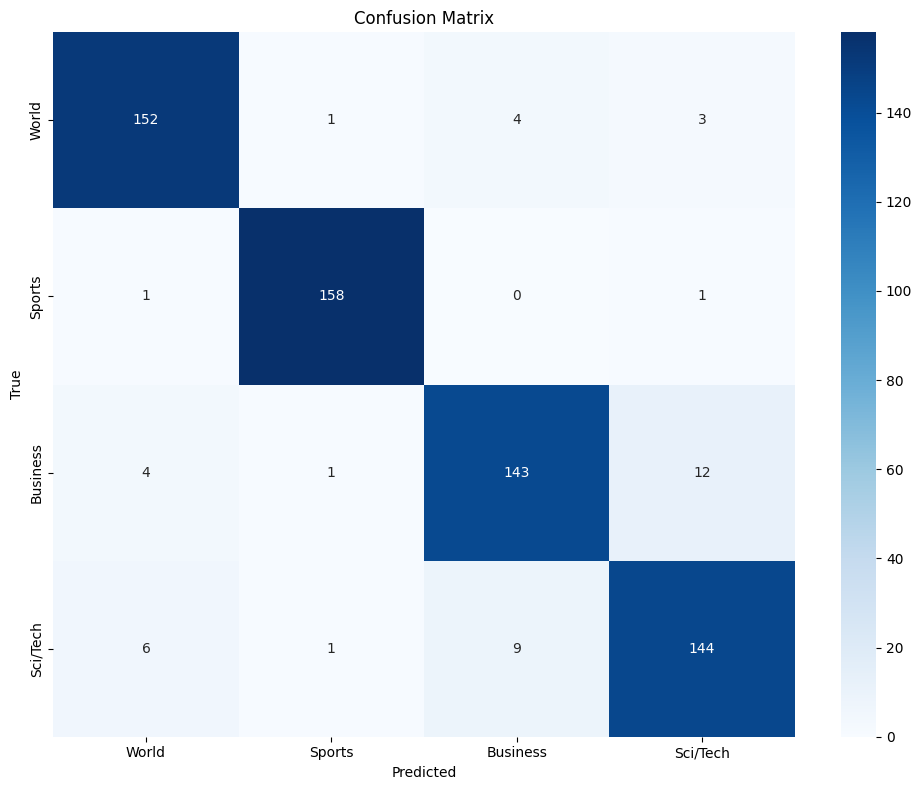

Evaluation Metrics:
Accuracy: 0.9328
Precision: 0.9326
Recall: 0.9328
F1 Score: 0.9327

Validation accuracy: 0.9328


In [26]:
# Check evaluation accuracy on validation set
eval_metrics, _ = evaluate_model(peft_model, eval_dataset, True, 32, data_collator)
print(f"\nValidation accuracy: {eval_metrics['accuracy']:.4f}")

In [27]:

# Process unlabelled test data
try:
    print("\nProcessing unlabelled test data...")
    unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")

    # For unlabelled dataset, check its structure
    print(f"Unlabelled dataset keys: {unlabelled_dataset.column_names if hasattr(unlabelled_dataset, 'column_names') else 'N/A'}")

    # If it's a pandas DataFrame, convert to HF Dataset
    if isinstance(unlabelled_dataset, pd.DataFrame):
        print("Converting DataFrame to Dataset")
        unlabelled_dataset = Dataset.from_pandas(unlabelled_dataset)

    # Preprocess the test data the same way as training data
    test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
    print(f"Loaded {len(test_dataset)} unlabelled test samples")

    # Run inference and save predictions
    print("Running inference on test dataset...")
    preds = evaluate_model(peft_model, test_dataset, False, 32, data_collator)

    df_output = pd.DataFrame({
        'ID': range(len(preds)),
        'Label': preds.numpy()  # Convert to numpy for saving
    })

    # Save predictions to CSV for submission
    submission_path = os.path.join(output_dir, "inference_output.csv")
    df_output.to_csv(submission_path, index=False)
    print(f"Inference complete. Predictions saved to {submission_path}")

    # Check the first few predictions
    print("\nSample predictions:")
    for i in range(min(5, len(df_output))):
        pred_class = df_output['Label'][i]
        print(f"Sample {i}: Predicted class: {pred_class} ({id2label[pred_class]})")

except Exception as e:
    print(f"Error processing unlabelled test data: {e}")
    print("Skipping test data processing - you'll need to rerun this section when you have the test data.")


Processing unlabelled test data...
Unlabelled dataset keys: ['text']


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Loaded 8000 unlabelled test samples
Running inference on test dataset...


100%|██████████| 250/250 [00:29<00:00,  8.47it/s]

Inference complete. Predictions saved to results/inference_output.csv

Sample predictions:
Sample 0: Predicted class: 3 (Sci/Tech)
Sample 1: Predicted class: 0 (World)
Sample 2: Predicted class: 0 (World)
Sample 3: Predicted class: 3 (Sci/Tech)
Sample 4: Predicted class: 1 (Sports)


In [28]:

# Final parameter check
final_trainable_params, final_all_params = count_trainable_parameters(peft_model)
print("\nFinal Model Parameters:")
print(f"Total parameters: {final_all_params:,}")
print(f"Trainable parameters: {final_trainable_params:,}")
print(f"Percentage of parameters that are trainable: {100 * final_trainable_params / final_all_params:.2f}%")
print(f"Under 1M parameter limit: {'Yes' if final_trainable_params <= 1_000_000 else 'No'}")


Final Model Parameters:
Total parameters: 125,629,448
Trainable parameters: 980,740
Percentage of parameters that are trainable: 0.78%
Under 1M parameter limit: Yes


In [29]:

# Save the final model
final_model_path = os.path.join(output_dir, "final_model")
peft_lora_finetuning_trainer.save_model(final_model_path)
print(f"Final model saved to {final_model_path}")

print("\nTraining and evaluation complete! The model is ready for submission.")
print(f"Final accuracy: {eval_metrics['accuracy']:.4f}")
print(f"The model uses {final_trainable_params:,} trainable parameters (limit: 1,000,000)")

Final model saved to results/final_model

Training and evaluation complete! The model is ready for submission.
Final accuracy: 0.9328
The model uses 980,740 trainable parameters (limit: 1,000,000)
